<h1>FIFA 23 ML Project  <img src="https://img.icons8.com/color/48/null/football-team.png"/></h1>

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("../players_fifa23.csv")
data.head()

,ID,Name,FullName,Age,Height,Weight,PhotoUrl,Nationality,Overall,Potential,...,LMRating,CMRating,RMRating,LWBRating,CDMRating,RWBRating,LBRating,CBRating,RBRating,GKRating
0,158023,L. Messi,Lionel Messi,35,169,67,https://cdn.sofifa.net/players/158/023/23_60.png,Argentina,91,91,...,91,88,91,67,66,67,62,53,62,22
1,165153,K. Benzema,Karim Benzema,34,185,81,https://cdn.sofifa.net/players/165/153/23_60.png,France,91,91,...,89,84,89,67,67,67,63,58,63,21
2,188545,R. Lewandowski,Robert Lewandowski,33,185,81,https://cdn.sofifa.net/players/188/545/23_60.png,Poland,91,91,...,86,83,86,67,69,67,64,63,64,22
3,192985,K. De Bruyne,Kevin De Bruyne,31,181,70,https://cdn.sofifa.net/players/192/985/23_60.png,Belgium,91,91,...,91,91,91,82,82,82,78,72,78,24
4,231747,K. Mbappé,Kylian Mbappé,23,182,73,https://cdn.sofifa.net/players/231/747/23_60.png,France,91,95,...,92,84,92,70,66,70,66,57,66,21


In [4]:
data.shape

(18539, 90)

In [5]:
needed_columns = ['ID', 'Name', 'Age', 'Height', 'Weight',
       'Overall', 'Potential', 'Growth', 'TotalStats',
       'BaseStats', 'BestPosition', 'Club', 'ValueEUR', 'WageEUR',
       'ReleaseClause', 'ContractUntil', 'ClubJoined', 'OnLoad',
       'PreferredFoot', 'IntReputation', 'WeakFoot','Nationality',
       'SkillMoves', 'AttackingWorkRate', 'DefensiveWorkRate', 'PaceTotal',
       'ShootingTotal', 'PassingTotal', 'DribblingTotal', 'DefendingTotal',
       'PhysicalityTotal', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']


data = data[needed_columns]

# Data Preprocessing:

<h3>1. Handle the missing values:</h3>

In [6]:
for i in data.columns:
    if data[i].isnull().sum() > 0:
        print(i, " ", data[i].isnull().sum())

ContractUntil   92


<h4>ContractUntil Column:</h4>

In [7]:
print("The percentage of the null values is: ", (data["ContractUntil"].isnull().sum()/data.shape[0])*100, "%")

The percentage of the null values is:  0.49625114623226707 %


As the percentage of nulls is small so we can drop the values of nulls in that column.

In [8]:
data.drop(data[data["ContractUntil"].isnull()].index, axis = 0, inplace =True)

In [9]:
data["ContractUntil"].isnull().sum()

0

<h3>2. Handle The Categorical Columns:</h3>

In [10]:
for i in data.columns:
    if data[i].dtype == 'object':
        print(i)

Name
BestPosition
Club
PreferredFoot
Nationality
AttackingWorkRate
DefensiveWorkRate


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data["PreferredFoot"] = le.fit_transform(data["PreferredFoot"])
data["AttackingWorkRate"] = le.fit_transform(data["AttackingWorkRate"])
data["DefensiveWorkRate"] = le.fit_transform(data["DefensiveWorkRate"])
data["Club"] = le.fit_transform(data["Club"])


<h3>Merge Some Players Positions to reduce the number of classes:</h3>

In [12]:
merge_pos = {'LWB' : 'LW', 'RWB': 'RW', 'ST': 'CF', 'CAM': 'CM', 'CDM': 'CM'}

data = data.replace({'BestPosition': merge_pos})

In [13]:
mapping = {'CF': 0, 'CM': 1, 'RW': 2, 'GK': 3, 'CB': 4, 'LW': 5, 'LM': 6, 'LB': 7,'RM': 8, 'RB': 9}

data = data.replace({'BestPosition': mapping})

<h2>Split the Data to Train and Test sets:</h2>

In [14]:
X = data.drop(["BestPosition", "Nationality", "ID"], axis = 1)
Y = pd.DataFrame(data["BestPosition"])

top = data.sort_values(by=["Overall"], ascending=False).head(20)

In [15]:
from sklearn.model_selection import train_test_split
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [16]:
X_Train = X_Train.drop(["Name"], axis = 1)
test_names = X_Test["Name"]
X_Test = X_Test.drop(["Name"], axis = 1)

top_pos = top["BestPosition"]
top_names = top["Name"]
top = top.drop(["Name", "BestPosition", "Nationality", "ID"], axis = 1)

<h3>3. Handle the Imbalanced Data:</h3>

<AxesSubplot:xlabel='BestPosition', ylabel='count'>

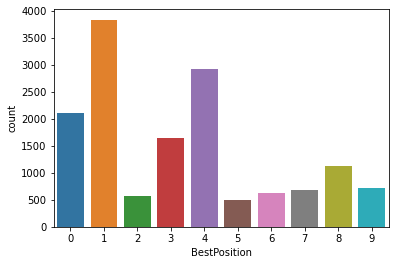

In [17]:
sns.countplot(x="BestPosition", data = Y_Train)

In [18]:
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling  import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_Train, Y_Train = oversample.fit_resample(X_Train, Y_Train)
X_Train, Y_Train = oversample.fit_resample(X_Train, Y_Train)
X_Train, Y_Train = oversample.fit_resample(X_Train, Y_Train)
X_Train, Y_Train = oversample.fit_resample(X_Train, Y_Train)

In [19]:
print(f' X_shape: {X_Train.shape} \n y_shape: {Y_Train.shape}')

 X_shape: (27732, 61) 
 y_shape: (27732, 1)


<AxesSubplot:xlabel='BestPosition', ylabel='count'>

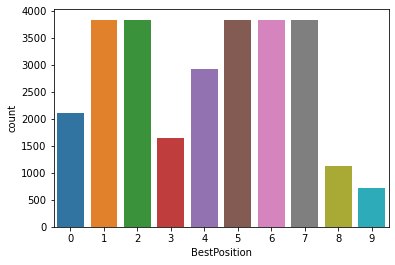

In [20]:
sns.countplot(x="BestPosition", data = Y_Train)

<h3>4. Feature Scaling:</h3>

In [21]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

X_Train = mms.fit_transform(X_Train)
X_Test = mms.fit_transform(X_Test)

top = mms.fit_transform(top)

# Modeling

## A. Predict the Position of the Player Using 8 Classification Algorithms:

<h3>3. XGB:</h3>

In [22]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

In [23]:
xgb.fit(X_Train, Y_Train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [25]:
import pickle

pickle.dump(xgb, open("model.pkl", "wb"))